In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
shots_spot_train = pd.read_csv('./assets/mpd/shots_spot_train.csv', index_col='Unnamed: 0')
shots_spot_test  = pd.read_csv('./assets/mpd/shots_spot_test.csv', index_col='Unnamed: 0')

In [3]:
# One cell did not macth up and will be filled with a zero 
shots_spot_train.fillna(0, inplace=True)
shots_spot_test.fillna(0, inplace=True)

In [4]:
# Set date to Datetime for Temporal Comparisons
shots_spot_train.date = pd.to_datetime(shots_spot_train.date)
shots_spot_test.date = pd.to_datetime(shots_spot_test.date)

shots_spot_train = shots_spot_train.set_index('date')
shots_spot_test  = shots_spot_test.set_index('date')

In [6]:
#Create aggregate variable total gunshots 
shots_spot_train['total_gunshots'] = shots_spot_train['type_multiple_gunshots'] + \
                                     shots_spot_train['type_single_gunshot']

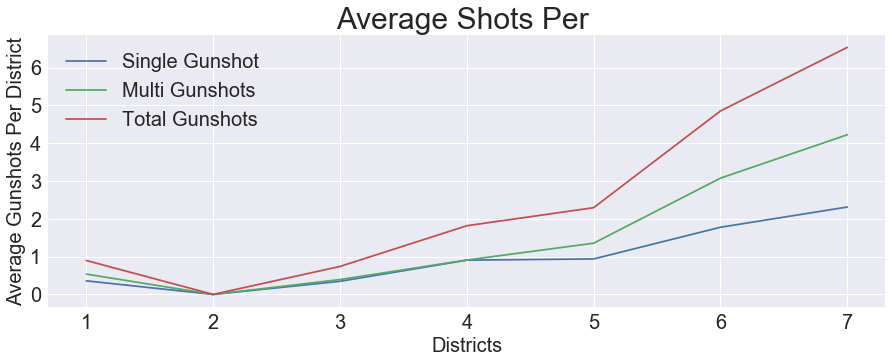

In [7]:
# Better Understanding Average shots per each district.
grouped = shots_spot_train.groupby('district')

plt.figure(figsize=(15, 5))
plt.plot(grouped['type_single_gunshot'].agg(np.mean), label='Single Gunshot')
plt.plot(grouped['type_multiple_gunshots'].agg(np.mean), label="Multi Gunshots")
plt.plot(grouped['total_gunshots'].agg(np.mean), label='Total Gunshots')
plt.title('Average Shots Per ', size=30)
plt.xticks(size=20)
plt.xlabel('Districts', size=20)
plt.ylabel('Average Gunshots Per District', size=20)
plt.yticks(size=20)
plt.legend(fontsize=20);

/anaconda3/envs/dsi/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


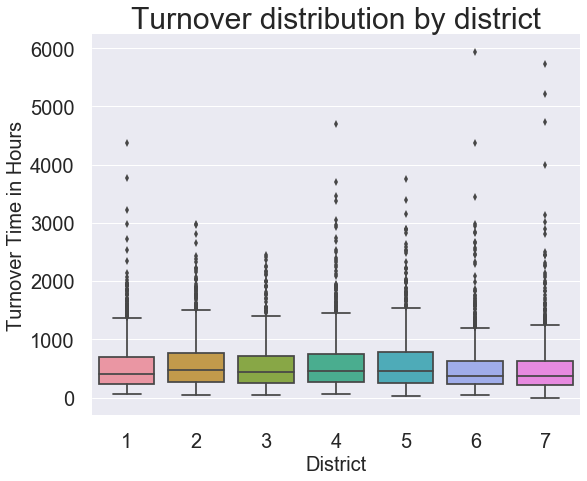

In [8]:
# Major Contributor to 311 Calls.  See how it spreads across each district.
plt.rcParams['figure.figsize'] = (8.75, 7.0)
ax = plt.axes()
plot1 = sns.boxplot(data=shots_spot_train, x='district', y='turnover')
ax.set_title("Turnover distribution by district", size=30)
sns.despine(offset=10, trim=True)
plt.xticks(size=20)
plt.xlabel('District', size=20)
plt.yticks(size=20)
plt.ylabel('Turnover Time in Hours', size=20)
plt.show()

### Testing to see the correlation when a shot occurs, how likely will it occur the next day over each year

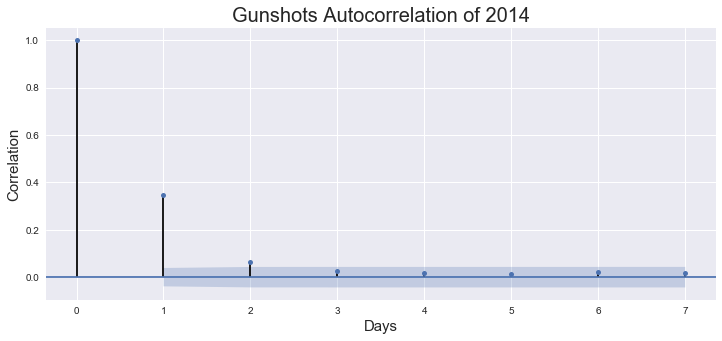

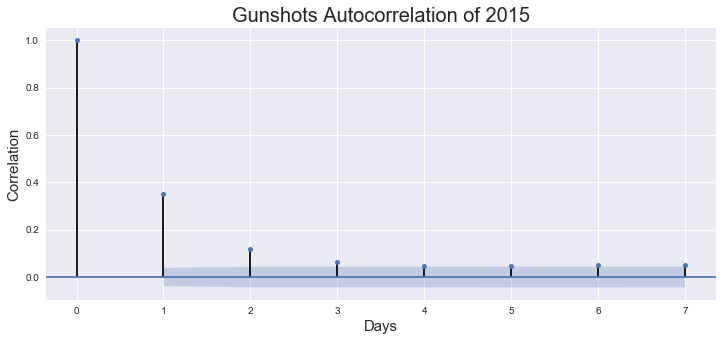

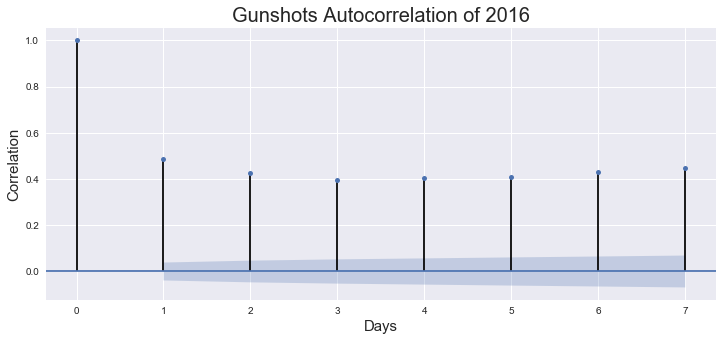

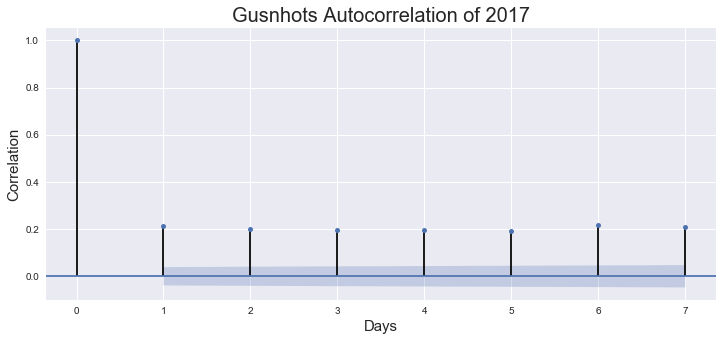

In [9]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(shots_spot_train['2014'].total_gunshots, lags=7, ax=ax)
ax.set_title('Gunshots Autocorrelation of 2014', size=20)
ax.set_xlabel('Days', size=15)
ax.set_ylabel('Correlation', size=15)

fig, ax = plt.subplots(figsize=(12,5))
plot_acf(shots_spot_train['2015'].total_gunshots, lags=7, ax=ax)
ax.set_title('Gunshots Autocorrelation of 2015', size=20)
ax.set_xlabel('Days', size=15)
ax.set_ylabel('Correlation', size=15)

fig, ax = plt.subplots(figsize=(12,5))
plot_acf(shots_spot_train['2016'].total_gunshots, lags=7, ax=ax)
ax.set_title('Gunshots Autocorrelation of 2016', size=20)
ax.set_xlabel('Days', size=15)
ax.set_ylabel('Correlation', size=15)

fig, ax = plt.subplots(figsize=(12,5))
plot_acf(shots_spot_train['2017'].total_gunshots, lags=7, ax=ax)
ax.set_title('Gusnhots Autocorrelation of 2017', size=20)
ax.set_xlabel('Days', size=15)
ax.set_ylabel('Correlation', size=15);

#### Modeling Classification first to test if we can predict which days will result in any kind of gunshot.

In [10]:
# Our initial target is the Multiple Gunshots
X = shots_spot_train.drop(['type_multiple_gunshots', 'type_single_gunshot', 'district'], axis=1)
y = shots_spot_train['type_multiple_gunshots']

In [11]:
# to make this a classification problem
def binary(y):
        if y > 0:
            return 1
        else:
            return 0

y = y.map(binary)

In [12]:
# baseline
y.value_counts(normalize=True)

0    0.599883
1    0.400117
Name: type_multiple_gunshots, dtype: float64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7670, 9), (2557, 9), (7670,), (2557,))

In [15]:
ss  = StandardScaler()
rfc = RandomForestClassifier()

In [16]:
X_train_s = ss.fit_transform(X_train)
X_test_s  = ss.transform(X_test)

### Overfitted Random Forest Model.  Does decent in Comparison from training to test.

In [43]:
rfc.fit(X_train_s, y_train)
print("Random Forest Train Score:", rfc.score(X_train_s, y_train))

Random Forest Train Score: 0.9958279009126467


In [44]:
print("Random Forest Test Score:", rfc.score(X_test_s, y_test))

Random Forest Test Score: 0.8991005084082909


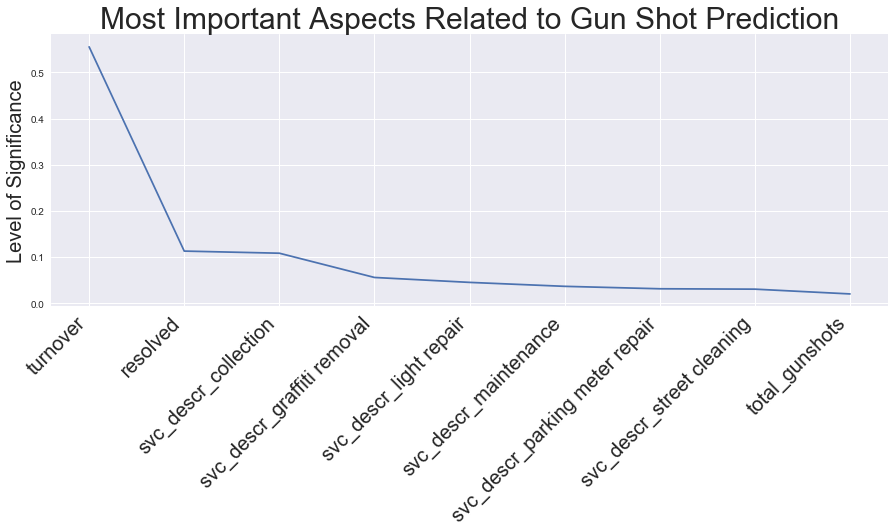

In [45]:
# Model the most important features in the our classifiers.
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(pd.Series(rfc.feature_importances_, index=X_train.columns).nlargest(9))
ax.set_title('Most Important Aspects Related to Gun Shot Prediction', size=30)
ax.set_ylabel('Level of Significance', size=20)
ax.set_xticklabels(X_train.columns, rotation=45, ha='right', minor=False, size=20);

### Regression Model to calculate how many shots will happen

In [46]:
X1_feat = shots_spot_train[shots_spot_train.district == 1].drop(['district', 'type_multiple_gunshots', 'type_single_gunshot'], axis=1)
y1_targ = shots_spot_train[shots_spot_train.district == 1]['type_multiple_gunshots']

In [47]:
lr = LinearRegression()

In [48]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_feat, y1_targ, random_state=42)

In [49]:
X1s_train = ss.fit_transform(X1_train)
X1s_test  = ss.transform(X1_test)

lr.fit(X1s_train, y1_train)

print("District One Linear Regression Train Score:", lr.score(X1s_train, y1_train))

print("\n District One Linear Regression Test Score:", lr.score(X1s_test, y1_test))

District One Linear Regression Train Score: 0.9523706496912332

 District One Linear Regression Test Score: 0.7738798420293598
